# Práctica 2
# Transformación de variables categóricas, clasificación con K Nearest Neighbor (KNN), optimización y visualización de resultados – préstamos en instituciones bancarias

En esta práctica aprenderás a realizar mediante un pipeline: transformación de variables categóricas y transformaciones numéricas. Utilizarás la clase columntransformer. Posteriormente, se realizará una clasificación mediante KNN para predecir si un cliente de un banco es un cliente adecuado (bueno-bajo riesgo) o un cliente no adecuado (malo-alto riesgo) para otorgarle un crédito.

Para ello, seguirás un proceso de análisis de datos en fases:

* Fase 1: preparación de datos
* Fase 2: clasificación con KNN, evaluación y optimización
* Fase 3: predicción de nuevos samples (nuevos clientes)


Se diseñará el modelo mediante KNeighborsRegressor, puesto que en este ejemplo se presentará la predicción de la clase del cliente, y además se presentará la certeza (confianza o probabilidad) asociada a esa predicción. El modelo KNN con una salida continua nos proporcionará información valiosa para calcular esa certeza. Aprenderás varias formas adicionales de transformación numérica mediante la clase preprocessing: normalización, L1, L2, scaling, estandarización.

Se ejecutará el modelo KNN con diferentes distancias (por ejemplo, euclidiana, manhattan, chebyshev y una personalizada) y diferentes valores de K (10, 20, 30, etc.) para evaluar y optimizar el rendimiento del modelo. Finalmente, se visualizará los resultados de los experimentos.

## Fundamentos

### Tipos de transformaciones de variables numéricas

**Normalización:**  transformación al rango entre 0 y 1

**Scaling**: transformación a umbrales mínimo y máximo (pueden ser diferentes de 0 y 1)

**Estandarización**: transformación de datos (media=0, varianza=1)

Los transformadores generalmente se combinan con clasificadores, regresores u otros estimadores para construir un estimador compuesto. La herramienta más común para combinar transformadores es un **Pipeline**.


## Algoritmo KNN

K-Nearest Neighbor (kNN) es un algoritmo de clasificación y regresión simple pero efectivo que se utiliza para asignar puntos de datos a una clase basada en la mayoría de los votos de sus k vecinos más cercanos [2]. Puede utilizarse en problemas de clasificación, donde el objetivo es predecir una categoría o etiqueta, o en problemas de regresión, donde el objetivo es predecir un valor numérico [3].

KNN es posiblemente el clasificador más intuitivo, que utiliza la distancia entre los ejemplos de entrenamiento como medida de similitud. La distancia entre los puntos representa la diferencia entre los valores de sus funciones. Dado un nuevo punto de datos, un clasificador KNN debe ver los puntos de entrenamiento más cercanos. La clase predicha para el nuevo punto será la clase más común entre los K neighbors [4].

**Pasos del KNN**:

* Calcular las distancias (con medidas de distancia o similaridad)
* Ordenar las distancias e identificar los K vecinos (elementos más cercanos)
* Calcular la decisión. En clasificación sería la clase (función de agregación clásica – el valor más frecuente). En regresión sería un   valor continuo (función de agregación clásica – el promedio).


## FASE 1: Preparación de datos

### Importación de librerias

In [1]:
from time import time
from datetime import datetime, timedelta
import pandas as pd  
import numpy as np  
from matplotlib import*
from matplotlib.cm import register_cmap
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier #KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#from keras.layers import Dropout

from sklearn import metrics 
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from scipy import stats
import seaborn
from sklearn import set_config                      
print('Módulos importados')

Módulos importados


### Carga de dataset
Nombre del dataset: Statlog (German Credit Data)
Enlace: http://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

Descripción general: Este conjunto de datos clasifica a las personas descritas por un conjunto de atributos como riesgos crediticios buenos o malos.

Número de Variables (o atributos): 21

Número de instancias (clientes en el banco): 1000

Salida: TIPOCLIENTE (BUEN CLIENTE O BAJO RIESGO:1, MAL CLIENTE O ALTO RIESGO:2)

In [2]:
nombresVariables=['ESTADOCUENTACORRIENTE','PLAZOMESESCREDITO','HISTORIALCREDITO','PROPOSITOCREDITO','MONTOCREDITO',
                  'SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO','TASAPAGO','ESTADOCIVILYSEXO','GARANTE','TIEMPORESIDENCIAACTUAL',
                  'ACTIVOS','EDAD','OTROSPLANESPAGO','VIVIENDA','CANTIDADCREDITOSEXISTENTES','EMPLEO',
                  'CANTIDADPERSONASAMANTENER','TELEFONO','TRABAJADOREXTRANJERO','TIPOCLIENTE']
#Cargar un dataframe desde una URL
dfOriginal = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data', sep = ' ', 
                         names=nombresVariables)
#Cargar un dataframe de un archivo local
#dataset = "Datasets/german.data"
#dfOriginal = pd.read_csv(dataset, sep = ' ', names=nombresVariables)

print('cantidad de observaciones (clientes): ',dfOriginal.shape[0])
print('cantidad de variables: ',dfOriginal.shape[1])
print(dfOriginal.shape)
dfOriginal.head()

cantidad de observaciones (clientes):  1000
cantidad de variables:  21
(1000, 21)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


### Formato a la variable de salida

In [3]:
#Se modifica la variable de salida (de estudio): TIPOCLIENTE. Es mejor tener la salida en formato binario cuando hay dos clases
dfOriginal=dfOriginal.replace(2, 0)
dfOriginal.head()

,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,...,ACTIVOS,EDAD,OTROSPLANESPAGO,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TELEFONO,TRABAJADOREXTRANJERO,TIPOCLIENTE
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,0,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,0,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,0,A93,A101,...,A121,49,A143,A152,1,A172,0,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,0,A93,A103,...,A122,45,A143,A153,1,A173,0,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,0,A173,0,A191,A201,0


### Eliminación de variables y separación de variable de salida

In [4]:
dataframe=copy.deepcopy(dfOriginal)
print(dataframe.shape)
#Se separa la variable de salida "Y" para poder realizar la preparación de datos a las variables independiente "X" 
Y=dataframe['TIPOCLIENTE']
dataframe=dataframe.drop(['OTROSPLANESPAGO'], axis=1)
dataframe=dataframe.drop(['TELEFONO'], axis=1)
dataframe=dataframe.drop(['TIPOCLIENTE'], axis=1)
print(dataframe.shape)
dataframe.head()

(1000, 21)
(1000, 18)


,ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,TIEMPORESIDENCIAACTUAL,ACTIVOS,EDAD,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TRABAJADOREXTRANJERO
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A152,0,A173,1,A201
1,A12,48,A32,A43,5951,A61,A73,0,A92,A101,0,A121,22,A152,1,A173,1,A201
2,A14,12,A34,A46,2096,A61,A74,0,A93,A101,3,A121,49,A152,1,A172,0,A201
3,A11,42,A32,A42,7882,A61,A74,0,A93,A103,4,A122,45,A153,1,A173,0,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A153,0,A173,0,A201


### Análisis de variables categóricas

In [5]:
#Determinación de tipos de variables
categorical_ordinal_features = ['ESTADOCUENTACORRIENTE','HISTORIALCREDITO','SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO',
                                'ESTADOCIVILYSEXO','ACTIVOS','VIVIENDA','EMPLEO']
categorical_nominal_features = ['PROPOSITOCREDITO','GARANTE','TRABAJADOREXTRANJERO']
numeric_features = ['PLAZOMESESCREDITO','MONTOCREDITO','TASAPAGO','TIEMPORESIDENCIAACTUAL','EDAD','CANTIDADCREDITOSEXISTENTES',
                    'CANTIDADPERSONASAMANTENER']

In [6]:
def analisisVariables(dataframe, categorical_ordinal_features, categorical_nominal_features):
    cantidadTotalVariables = len(dataframe.columns) 
    print('Cantidad de variables antes de transformación de variables: ',cantidadTotalVariables)
    cantidadVariablesNominales = len(categorical_nominal_features)
    cantidadVariablesBinarias=0
    for variable in categorical_nominal_features:
        cantidadCategorias=dataframe[variable].nunique()
        cantidadVariablesBinarias=cantidadVariablesBinarias+cantidadCategorias
        print('Cantidad de categorías en la variable categórica nominal',variable,':',cantidadCategorias)
    print('Cantidad de variables binarias que reemplazarán a las variables categóricas nominales: ',cantidadVariablesBinarias)
    cantidadTotalVariablesConTransformacion = cantidadTotalVariables - cantidadVariablesNominales + cantidadVariablesBinarias
    return cantidadTotalVariablesConTransformacion

In [7]:
cantidadTotalVariablesConTransformacion=analisisVariables(dataframe, categorical_ordinal_features, categorical_nominal_features)
print('Cantidad de variables que habrá después de la transformación de variables: ',cantidadTotalVariablesConTransformacion)

Cantidad de variables antes de transformación de variables:  18
Cantidad de categorías en la variable categórica nominal PROPOSITOCREDITO : 10
Cantidad de categorías en la variable categórica nominal GARANTE : 3
Cantidad de categorías en la variable categórica nominal TRABAJADOREXTRANJERO : 2
Cantidad de variables binarias que reemplazarán a las variables categóricas nominales:  15
Cantidad de variables que habrá después de la transformación de variables:  30


### Diseño de transformadores

Por medio de un Pipeline creamos un estimador compuesto. Esta herramienta nos permite combinar preprocesadores y transformadores para llevar un orden y estructura en el proceso de transformación de variables. Para una mejor organización creamos los preprocesadores y sus métodos de transformación.

In [8]:
#Definición de transformadores (preprocesadores)

#1. Preprocesador de variables categóricas a numéricas (ordinales y nominales)
categorical_ordinal_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())])

categorical_nominal_transformer_ConNombres = Pipeline(steps=[
    ('onehot', OneHotEncoder(sparse = False, handle_unknown = "ignore"))])# se ignorará una categoría desconocida

preprocesorCategoricoNumericoConNombres = ColumnTransformer(
    transformers=[
        ('catord', categorical_ordinal_transformer, categorical_ordinal_features),
        ('catnom', categorical_nominal_transformer_ConNombres, categorical_nominal_features)
    ],remainder='passthrough',n_jobs=-1)

#2. Normalización y Scaling: Preprocesador de variables numéricas con transformación MinMaxScaler
minmax_transformer = Pipeline(steps=[
    ('minmax', MinMaxScaler(feature_range=(0, 1)))])

preprocesorMinMax = ColumnTransformer(transformers =[
    ('tranminmax', minmax_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

#3. Estandarización: Preprocesador de variables numéricas con transformación StandardScaler
standardscaler_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=True,with_std=True))])
preprocesorStandardScaler = ColumnTransformer(transformers =[
    ('transcaler', standardscaler_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

#4. Preprocesador de variables numéricas con transformación SimpleImputer
simpleimputer_transformer = Pipeline(steps=[
    ('simpleimputer', SimpleImputer(strategy='median')) #otras: strategy='constant', strategy='most_frequent'
])
preprocesorSimpleImputer = ColumnTransformer(transformers =[
('transimpleimputer', simpleimputer_transformer, list(range(cantidadTotalVariablesConTransformacion)))
], remainder ='passthrough')

### Diseño de pipeline
El procesador ‘prepcn’ es indispensable que se aplique antes de los demás preprocesadores numéricos. En el Pipeline “pipe” se aplica primeramente la tansformación de variables categóricas a variables numéricas y en segundo lugar se aplica la transformación numérica.

In [9]:
#Construcción de Pipeline con transformadores
pipe = Pipeline(steps=[
    ('prepcn', preprocesorCategoricoNumericoConNombres), 
    #('prepstandard', preprocesorStandardScaler)
    ('prepminmax', preprocesorMinMax)
])

### Transformación de variables

In [32]:
#Se ejecuta el pipeline
dataframeTransformado=copy.deepcopy(dataframe)
X_Transformado = pipe.fit_transform(dataframeTransformado)
print('********** Pipeline aplicado')
print('********** Transformador categórico nominal:')
print(pipe.named_steps['prepcn'].transformers_[1])
#Formación de dataframe transformado
cnamesDataset1=[]
if len(categorical_ordinal_features)!=0:
    cnamesDataset1.extend(categorical_ordinal_features)
if len(categorical_nominal_features)!=0:
    #nos ubicamos primeramente en el paso "prepcn" 
    #luego, en el transformador "catnom" que está en [1] y luego en "onehot", por eso [1][1] 
    cnamesDataset2 = pipe.named_steps['prepcn'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_nominal_features)
    cnamesDataset1.extend(cnamesDataset2)
cnamesDataset3 = numeric_features
cnamesDataset1.extend(cnamesDataset3)
print('********** Lista de variables:')
print(cnamesDataset1)
dataframeTransformado = pd.DataFrame(data=X_Transformado,columns=cnamesDataset1)
#Guardar el dataset sin etiquetas como csv
#dataframeTransformado.to_csv("DatasetTransformadoSinEtiquetas.csv", sep=";",index = False)
#Se agrega la variable de salida (etiquetas) al final
dataframeTransformado = pd.concat([dataframeTransformado, Y], axis = 1)
#Guardar el dataset con etiquetas como csv
dataframeTransformado.to_csv("DatasetTransformadoConEtiquetas.csv", sep=";",index = False)
dataframeTransformado.head()


********** Pipeline aplicado
********** Transformador categórico nominal:
('catnom', Pipeline(steps=[('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse=False,
                               sparse_output=False))]), ['PROPOSITOCREDITO', 'GARANTE', 'TRABAJADOREXTRANJERO'])
********** Lista de variables:
['ESTADOCUENTACORRIENTE', 'HISTORIALCREDITO', 'SALDOCUENTAAHORROS', 'TIEMPOACTUALEMPLEO', 'ESTADOCIVILYSEXO', 'ACTIVOS', 'VIVIENDA', 'EMPLEO', 'PROPOSITOCREDITO_A40', 'PROPOSITOCREDITO_A41', 'PROPOSITOCREDITO_A410', 'PROPOSITOCREDITO_A42', 'PROPOSITOCREDITO_A43', 'PROPOSITOCREDITO_A44', 'PROPOSITOCREDITO_A45', 'PROPOSITOCREDITO_A46', 'PROPOSITOCREDITO_A48', 'PROPOSITOCREDITO_A49', 'GARANTE_A101', 'GARANTE_A102', 'GARANTE_A103', 'TRABAJADOREXTRANJERO_A201', 'TRABAJADOREXTRANJERO_A202', 'PLAZOMESESCREDITO', 'MONTOCREDITO', 'TASAPAGO', 'TIEMPORESIDENCIAACTUAL', 'EDAD', 'CANTIDADCREDITOSEXISTENTES', 'CANTIDADPERSONASAMANTENER']


,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER,TIPOCLIENTE
0,0.000000,1.00,1.0,1.00,0.666667,0.000000,0.5,0.666667,0.0,0.0,...,1.0,0.0,0.029412,0.050567,1.00,1.00,0.857143,0.00,1.0,1
1,0.333333,0.50,0.0,0.50,0.333333,0.000000,0.5,0.666667,0.0,0.0,...,1.0,0.0,0.647059,0.313690,0.00,0.00,0.053571,0.25,1.0,0
2,1.000000,1.00,0.0,0.75,0.666667,0.000000,0.5,0.333333,0.0,0.0,...,1.0,0.0,0.117647,0.101574,0.00,0.75,0.535714,0.25,0.0,1
3,0.000000,0.50,0.0,0.75,0.666667,0.333333,1.0,0.666667,0.0,0.0,...,1.0,0.0,0.558824,0.419941,0.00,1.00,0.464286,0.25,0.0,1
4,0.000000,0.75,0.0,0.50,0.666667,1.000000,1.0,0.666667,1.0,0.0,...,1.0,0.0,0.294118,0.254209,0.75,1.00,0.607143,0.00,0.0,0


### Cargar y guardar Pipeline o Modelo

In [13]:
# Funciones para guardar y cargar un Pipeline o Modelo
def guardarPipeline(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)

def cargarPipeline(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline

In [14]:
guardarPipeline(pipe,'pipePreprocesadores')
pipe=None
pipe=cargarPipeline('pipePreprocesadores')
set_config(display='diagram')
pipe

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('catord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['ESTADOCUENTACORRIENTE',
                                                   'HISTORIALCREDITO',
                                                   'SALDOCUENTAAHORROS',
                                                   'TIEMPOACTUALEMPLEO',
                                                   'ESTADOCIVILYSEXO',
                                                   'ACTIVOS', 'VIVIENDA',
                                                   'EMPLEO']),
                                                 ('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['PROPOSITOCREDITO',
                                                   'GARANTE',
                                                   'TRABAJADOREXTRANJERO'])])),
                ('prepminmax',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tranminmax',
                                                  Pipeline(steps=[('minmax',
                                                                   MinMaxScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28,
                                                   29])]))])

### Análisis de correlación

En esta subsección se realiza un mapa de calor de las correlaciones entre todas las variables para identificar las variables más relevantes e influyentes a la variable de salida.

In [15]:
dfCorrel=copy.deepcopy(dataframeTransformado)
dfCorrel=dfCorrel.corr()
dfCorrel.head()

,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER,TIPOCLIENTE
ESTADOCUENTACORRIENTE,1.000000,0.192191,0.222867,0.106339,0.043261,-0.032260,0.022424,0.040663,-0.069559,0.064303,...,0.026758,-0.026758,-0.072013,-0.042705,-0.014511,-0.089823,0.059751,-0.073304,0.014145,0.350847
HISTORIALCREDITO,0.192191,1.000000,0.039058,0.138225,0.042171,-0.053777,0.062095,0.010350,0.042480,0.039096,...,-0.013873,0.013873,-0.077186,-0.059905,0.037965,0.037288,0.147086,-0.213422,-0.011550,0.228785
SALDOCUENTAAHORROS,0.222867,0.039058,1.000000,0.120950,0.017349,0.018948,0.006505,0.011709,-0.002348,0.112880,...,-0.007095,0.007095,0.047661,0.064630,0.031956,0.060301,0.084245,-0.019082,-0.027514,0.178943
TIEMPOACTUALEMPLEO,0.106339,0.138225,0.120950,1.000000,0.111278,0.087187,0.111126,0.101225,-0.021232,0.039358,...,0.027232,-0.027232,0.057381,-0.008367,0.102712,0.208012,0.256227,-0.066201,-0.097192,0.116002
ESTADOCIVILYSEXO,0.043261,0.042171,0.017349,0.111278,1.000000,-0.006940,0.099579,-0.011956,0.014725,0.040694,...,-0.065618,0.065618,0.014789,-0.016091,0.089818,-0.047411,0.007783,0.009972,-0.122165,0.088184


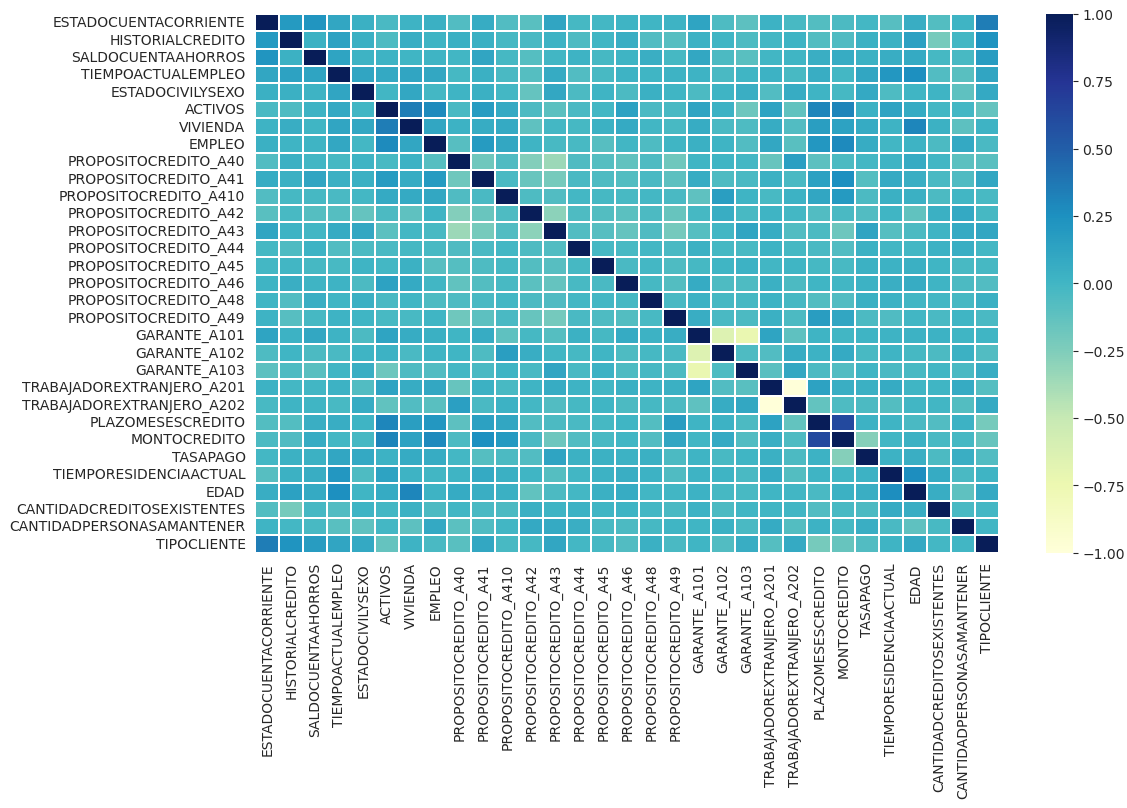

In [20]:
#Generar el mapa de calor de las correlaciones
mask = np.zeros_like(dfCorrel)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 7))
    #ax = sns.heatmap(dfCorrel, mask=mask, square=True, linewidths=.5, cmap="YlGnBu")
    #ax = sns.heatmap(dfCorrel, cmap ='viridis', linewidths = 0.30, annot = False)
    #ax = sns.heatmap(dfCorrel, cmap ='GnBu', linewidths = 0.30, annot = False)
    ax = sns.heatmap(dfCorrel, cmap ='YlGnBu', linewidths = 0.30, annot = False)
#plt.savefig('attribute_correlations.png')
plt.show()

### Se presenta las variables más correlacionadas positivamente con respecto a la variable de salida 

In [21]:

dfCorrOrdenado=dfCorrel.sort_values(by=['TIPOCLIENTE'], ascending=False)
dfCorrOrdenado['TIPOCLIENTE'].head(10)#Se presenta las variables más correlacionadas positivamente con respecto a la variable de salida 
dfCorrOrdenado=dfCorrel.sort_values(by=['TIPOCLIENTE'], ascending=False)
dfCorrOrdenado['TIPOCLIENTE'].head(10)

TIPOCLIENTE                  1.000000
ESTADOCUENTACORRIENTE        0.350847
HISTORIALCREDITO             0.228785
SALDOCUENTAAHORROS           0.178943
TIEMPOACTUALEMPLEO           0.116002
PROPOSITOCREDITO_A43         0.106922
PROPOSITOCREDITO_A41         0.099791
EDAD                         0.091127
ESTADOCIVILYSEXO             0.088184
TRABAJADOREXTRANJERO_A202    0.082079
Name: TIPOCLIENTE, dtype: float64

### Se presenta las variables más correlacionadas negativamente con respecto a la variable de salida

In [22]:
dfCorrOrdenado=dfCorrel.sort_values(by=['TIPOCLIENTE'], ascending=True)
dfCorrOrdenado['TIPOCLIENTE'].head(10)

PLAZOMESESCREDITO           -0.214927
MONTOCREDITO                -0.154739
ACTIVOS                     -0.142612
PROPOSITOCREDITO_A40        -0.096900
TRABAJADOREXTRANJERO_A201   -0.082079
PROPOSITOCREDITO_A46        -0.070088
TASAPAGO                    -0.066712
GARANTE_A102                -0.062728
PROPOSITOCREDITO_A49        -0.036129
EMPLEO                      -0.032735
Name: TIPOCLIENTE, dtype: float64

### Selección y extracción de variables
Se seleccionan las variables con mayor correlación. También se podría omitir este paso y continuar con todas las variables.

In [23]:
dataframeExtraccion=dataframeTransformado[['ESTADOCUENTACORRIENTE','HISTORIALCREDITO','SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO','PLAZOMESESCREDITO', 'MONTOCREDITO', 'ACTIVOS','TIPOCLIENTE']]
print(dataframeExtraccion.shape)
dataframeExtraccion.head()

(1000, 8)


,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,PLAZOMESESCREDITO,MONTOCREDITO,ACTIVOS,TIPOCLIENTE
0,0.000000,1.00,1.0,1.00,0.029412,0.050567,0.000000,1
1,0.333333,0.50,0.0,0.50,0.647059,0.313690,0.000000,0
2,1.000000,1.00,0.0,0.75,0.117647,0.101574,0.000000,1
3,0.000000,0.50,0.0,0.75,0.558824,0.419941,0.333333,1
4,0.000000,0.75,0.0,0.50,0.294118,0.254209,1.000000,0


### Generar todas las figuras de correlaciones entre cada par de variables

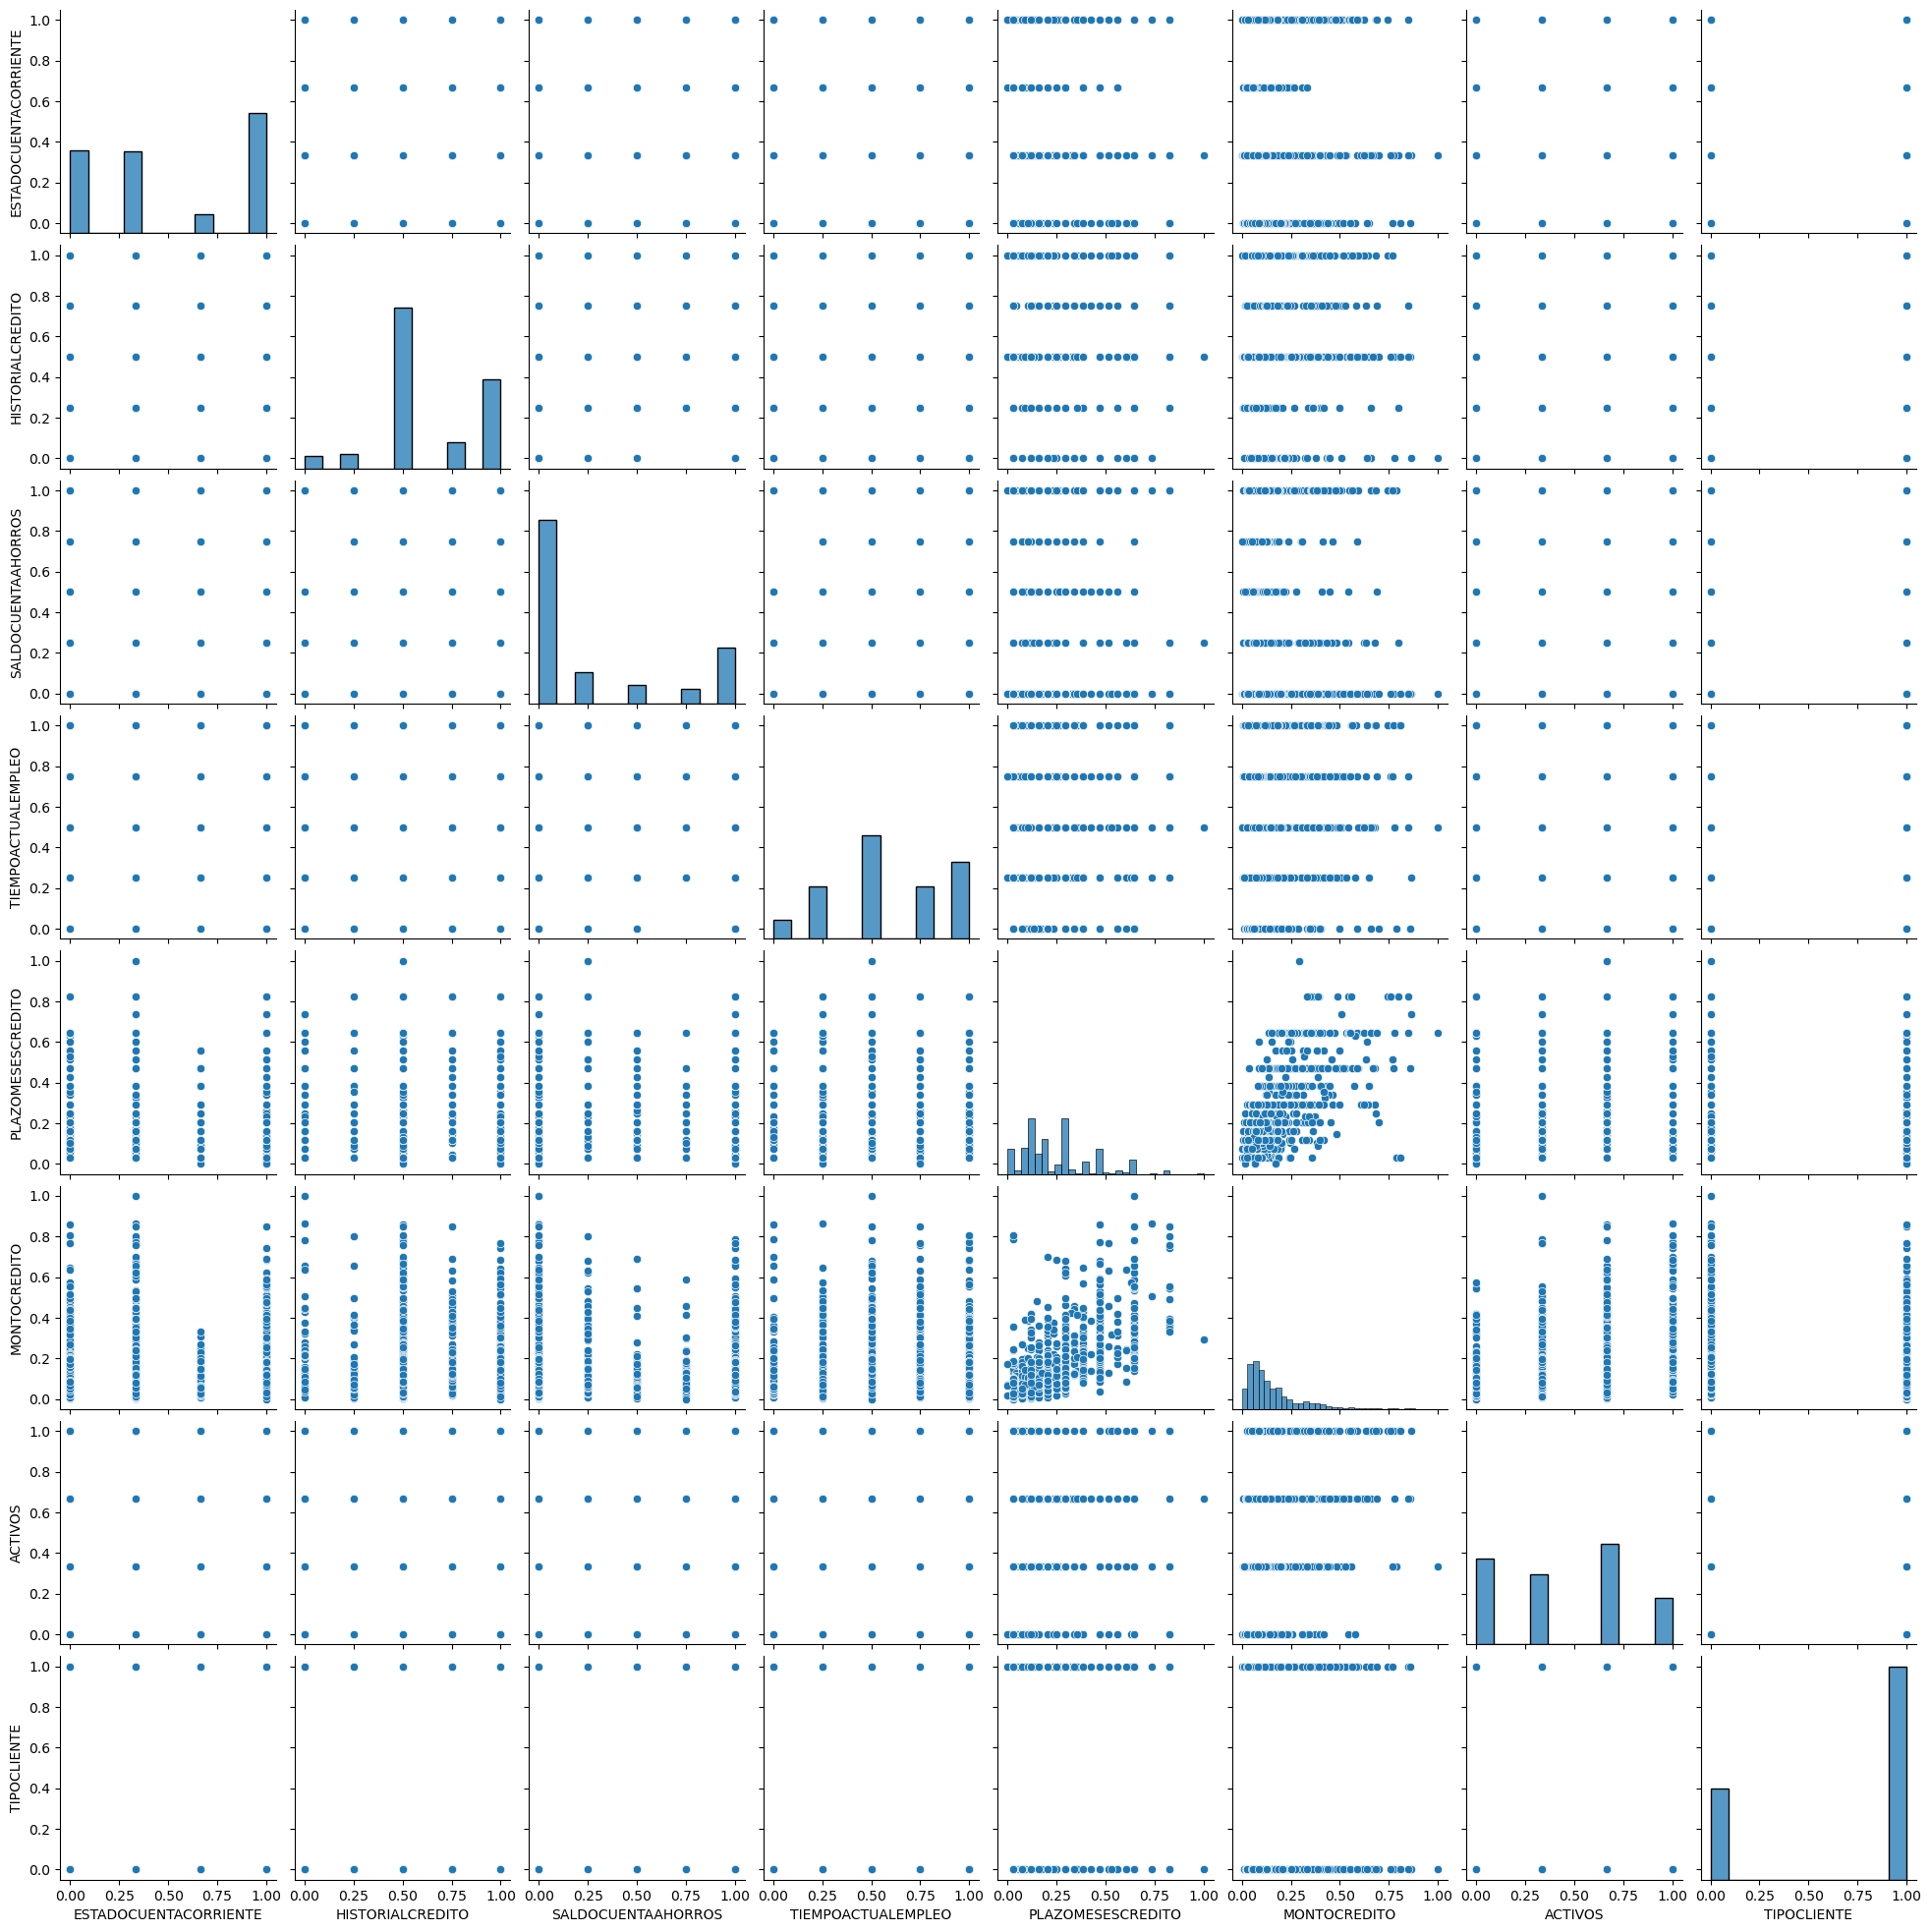

In [24]:
sns.pairplot(dataframeExtraccion)
plt.show()

### Transformación numérica adicional: Min max scaling

In [25]:
from sklearn import preprocessing
dataframeExtraccion=dataframeExtraccion.drop(['TIPOCLIENTE'], axis=1)


In [26]:
data_scaler_minmax = preprocessing.MinMaxScaler(feature_range=(0, 1))
data_scaled_minmax = data_scaler_minmax.fit_transform(dataframeExtraccion)
print("\nDatos normalizados con escala Min Max:\n")
DataframeTransformado1 = pd.DataFrame(data=data_scaled_minmax,columns=dataframeExtraccion.columns)
DataframeTransformado1 = pd.concat([DataframeTransformado1, dataframeTransformado[['TIPOCLIENTE']]], axis = 1)
#DataframeTransformado1.to_csv("DatasetBancoTransformadoMinMax.csv", sep=";",index = False) 
DataframeTransformado1.head()


Datos normalizados con escala Min Max:



,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,PLAZOMESESCREDITO,MONTOCREDITO,ACTIVOS,TIPOCLIENTE
0,0.000000,1.00,1.0,1.00,0.029412,0.050567,0.000000,1
1,0.333333,0.50,0.0,0.50,0.647059,0.313690,0.000000,0
2,1.000000,1.00,0.0,0.75,0.117647,0.101574,0.000000,1
3,0.000000,0.50,0.0,0.75,0.558824,0.419941,0.333333,1
4,0.000000,0.75,0.0,0.50,0.294118,0.254209,1.000000,0


### Transformación numérica adicional: Normalización L1 y L2

In [29]:
#Normalización L1: la suma de los valores absolutos es igual a 1
data_normalized_l1 = preprocessing.normalize(dataframeExtraccion, norm='l1')
#Normalización L2: la suma de los cuadrados es igual a 1
data_normalized_l2 = preprocessing.normalize(dataframeExtraccion, norm='l2')
print("\nDatos normalizados con L2:\n")

DataframeTransformado2 = pd.DataFrame(data=data_normalized_l1,columns=dataframeExtraccion.columns)
DataframeTransformado2 = pd.concat([DataframeTransformado2, dataframeTransformado[['TIPOCLIENTE']]], axis = 1)
#DataframeTransformado2.to_csv("DatasetBancoTransformadoNormL1.csv", sep=";",index = False)
DataframeTransformado2.head(10)

#DataframeTransformado3 = pd.DataFrame(data=data_normalized_l2,columns=dataframeExtraccion.columns)
#DataframeTransformado3 = pd.concat([DataframeTransformado3, dataframeTransformado[['TIPOCLIENTE']]], axis = 1)
#DataframeTransformado3.to_csv("DatasetBancoTransformadoNormL2.csv", sep=";",index = False)
#DataframeTransformado3.head()


Datos normalizados con L2:



,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,PLAZOMESESCREDITO,MONTOCREDITO,ACTIVOS,TIPOCLIENTE
0,0.000000,0.324678,0.324678,0.324678,0.009549,0.016418,0.000000,1
1,0.145301,0.217952,0.000000,0.217952,0.282056,0.136739,0.000000,0
2,0.336789,0.336789,0.000000,0.252592,0.039622,0.034209,0.000000,1
3,0.000000,0.195153,0.000000,0.292729,0.218112,0.163905,0.130102,1
4,0.000000,0.268017,0.000000,0.178678,0.105105,0.090843,0.357356,0
5,0.201813,0.100907,0.201813,0.100907,0.094971,0.097775,0.201813,1
6,0.265274,0.132637,0.132637,0.265274,0.078022,0.037732,0.088425,1
7,0.117407,0.176110,0.000000,0.176110,0.165750,0.129810,0.234813,1
8,0.305604,0.152802,0.229203,0.229203,0.035953,0.047235,0.000000,1
9,0.125474,0.376422,0.000000,0.000000,0.143926,0.103229,0.250948,0


### Transformación numérica adicional: Estandarización

In [30]:
XEstandarizado = preprocessing.scale(dataframeExtraccion)
print("\nDatos estandarizados:\n")

DataframeTransformado4 = pd.DataFrame(data=XEstandarizado,columns=dataframeExtraccion.columns)
DataframeTransformado4 = pd.concat([DataframeTransformado4, dataframeTransformado[['TIPOCLIENTE']]], axis = 1)
#DataframeTransformado4.to_csv("DatasetBancoTransformadoScale.csv", sep=";",index = False)
DataframeTransformado4.head()


Datos estandarizados:



,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,PLAZOMESESCREDITO,MONTOCREDITO,ACTIVOS,TIPOCLIENTE
0,-1.254566,1.344014,1.833169,1.338078,-1.236478,-0.745131,-1.293723,1
1,-0.459026,-0.503428,-0.699707,-0.317959,2.248194,0.949817,-1.293723,0
2,1.132053,1.344014,-0.699707,0.510060,-0.738668,-0.416562,-1.293723,1
3,-1.254566,-0.503428,-0.699707,0.510060,1.750384,1.634247,-0.341055,1
4,-1.254566,0.420293,-0.699707,-0.317959,0.256953,0.566664,1.564281,0


### Transformación de nuevos samples
La siguiente función permite transformar las variables de un nuevo cliente a un formato numérico. En la función se define el valor por defecto de las variables, se crea el dataframe con los nuevos valores y los nombres de las variables. Luego, se aplica la transformación de variables mediante el Pipeline.

In [31]:
def preprocesarNuevoCliente(ESTADOCUENTACORRIENTE='A12', PLAZOMESESCREDITO=6, HISTORIALCREDITO='A34', PROPOSITOCREDITO='A43',
                            MONTOCREDITO=1169, SALDOCUENTAAHORROS='A65', TIEMPOACTUALEMPLEO='A75', TASAPAGO=4, 
                            ESTADOCIVILYSEXO='A93', GARANTE='A101', TIEMPORESIDENCIAACTUAL=4, ACTIVOS='A121', EDAD=67, 
                            VIVIENDA='A152', CANTIDADCREDITOSEXISTENTES=2, EMPLEO='A173', CANTIDADPERSONASAMANTENER=2,
                            TRABAJADOREXTRANJERO='A201'):    
    cnames=['ESTADOCUENTACORRIENTE','PLAZOMESESCREDITO','HISTORIALCREDITO','PROPOSITOCREDITO','MONTOCREDITO',
            'SALDOCUENTAAHORROS','TIEMPOACTUALEMPLEO','TASAPAGO','ESTADOCIVILYSEXO','GARANTE','TIEMPORESIDENCIAACTUAL',
            'ACTIVOS','EDAD','VIVIENDA','CANTIDADCREDITOSEXISTENTES','EMPLEO','CANTIDADPERSONASAMANTENER',
            'TRABAJADOREXTRANJERO']
    Xnew=[ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,MONTOCREDITO,SALDOCUENTAAHORROS,
          TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,TIEMPORESIDENCIAACTUAL,ACTIVOS,EDAD,VIVIENDA,
          CANTIDADCREDITOSEXISTENTES,EMPLEO,CANTIDADPERSONASAMANTENER,TRABAJADOREXTRANJERO]
    Xnew_Dataframe = pd.DataFrame(data=[Xnew],columns=cnames)
    Xnew_Preprocesado = pipe.transform(Xnew_Dataframe)
    return Xnew_Preprocesado

ESTADOCUENTACORRIENTE='A12'
PLAZOMESESCREDITO=6
HISTORIALCREDITO='A34'
PROPOSITOCREDITO='A43'
MONTOCREDITO=1169
SALDOCUENTAAHORROS='A65'
TIEMPOACTUALEMPLEO='A75'
TASAPAGO=4
ESTADOCIVILYSEXO='A93'
GARANTE='A101'
TIEMPORESIDENCIAACTUAL=4 
ACTIVOS='A121'
EDAD=67
VIVIENDA='A152'
CANTIDADCREDITOSEXISTENTES=2
EMPLEO='A173'
CANTIDADPERSONASAMANTENER=2
TRABAJADOREXTRANJERO='A201'

Xnew_Preprocesado=preprocesarNuevoCliente(ESTADOCUENTACORRIENTE,PLAZOMESESCREDITO,HISTORIALCREDITO,PROPOSITOCREDITO,
                                          MONTOCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,TASAPAGO,ESTADOCIVILYSEXO,GARANTE,
                                          TIEMPORESIDENCIAACTUAL,ACTIVOS,EDAD,VIVIENDA,CANTIDADCREDITOSEXISTENTES,EMPLEO,
                                          CANTIDADPERSONASAMANTENER,TRABAJADOREXTRANJERO)
Xnew_Preprocesado

array([[0.33333333, 1.        , 1.        , 1.        , 0.66666667,
        0.        , 0.5       , 0.66666667, 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.02941176, 0.05056674,
        1.        , 1.        , 0.85714286, 0.5       , 2.        ]])

## Fase 2: Clasificación con el algoritmo KNN, evaluación y optimización

### Carga del dataset

A partir de la carga del dataset transformado se proceder con la fase de clasificación. Para ello, se debe indicar el csv deseado.

In [33]:
dataframeTransformado=pd.read_csv("DatasetTransformadoConEtiquetas.csv", sep=";")
dataframeTransformado['TIPOCLIENTE'] = dataframeTransformado['TIPOCLIENTE'].replace(2, 0)
print(dataframeTransformado.shape)
dataframeTransformado.head()

(1000, 31)


,ESTADOCUENTACORRIENTE,HISTORIALCREDITO,SALDOCUENTAAHORROS,TIEMPOACTUALEMPLEO,ESTADOCIVILYSEXO,ACTIVOS,VIVIENDA,EMPLEO,PROPOSITOCREDITO_A40,PROPOSITOCREDITO_A41,...,TRABAJADOREXTRANJERO_A201,TRABAJADOREXTRANJERO_A202,PLAZOMESESCREDITO,MONTOCREDITO,TASAPAGO,TIEMPORESIDENCIAACTUAL,EDAD,CANTIDADCREDITOSEXISTENTES,CANTIDADPERSONASAMANTENER,TIPOCLIENTE
0,0.000000,1.00,1.0,1.00,0.666667,0.000000,0.5,0.666667,0.0,0.0,...,1.0,0.0,0.029412,0.050567,1.00,1.00,0.857143,0.00,1.0,1
1,0.333333,0.50,0.0,0.50,0.333333,0.000000,0.5,0.666667,0.0,0.0,...,1.0,0.0,0.647059,0.313690,0.00,0.00,0.053571,0.25,1.0,0
2,1.000000,1.00,0.0,0.75,0.666667,0.000000,0.5,0.333333,0.0,0.0,...,1.0,0.0,0.117647,0.101574,0.00,0.75,0.535714,0.25,0.0,1
3,0.000000,0.50,0.0,0.75,0.666667,0.333333,1.0,0.666667,0.0,0.0,...,1.0,0.0,0.558824,0.419941,0.00,1.00,0.464286,0.25,0.0,1
4,0.000000,0.75,0.0,0.50,0.666667,1.000000,1.0,0.666667,1.0,0.0,...,1.0,0.0,0.294118,0.254209,0.75,1.00,0.607143,0.00,0.0,0


### Guardar modelo

In [34]:
# Función para guardar un modelo
def guardarModelo(pipeline,nombreArchivo):
    with open(nombreArchivo+'.pickle', 'wb') as handle:
        pickle.dump(pipeline, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print("********** Pickle guardado")

# Función para transformar la predicción         
def transformarPrediccion(lista):
    for i in range(len(lista)):
        desempenio=lista[i]
        #print(desempenio)
        if (desempenio < 0.5):
            desempenio = 0
        elif (desempenio >= 0.5):
            desempenio = 1
        lista[i]=desempenio
    return lista

In [35]:
Y = dataframeTransformado['TIPOCLIENTE']
dataframeTransformado=dataframeTransformado.drop(['TIPOCLIENTE'], axis=1)
X_Transformado=dataframeTransformado.values
X_Transformado

array([[0.        , 1.        , 1.        , ..., 0.85714286, 0.        ,
        1.        ],
       [0.33333333, 0.5       , 0.        , ..., 0.05357143, 0.25      ,
        1.        ],
       [1.        , 1.        , 0.        , ..., 0.53571429, 0.25      ,
        0.        ],
       ...,
       [1.        , 0.5       , 0.        , ..., 0.33928571, 0.25      ,
        1.        ],
       [0.        , 0.5       , 0.        , ..., 0.07142857, 0.25      ,
        1.        ],
       [0.33333333, 1.        , 0.25      , ..., 0.14285714, 0.25      ,
        1.        ]])

### Diseño y optimización

En esta sección se evalúa el método KNN con distintos valores de parámetros. El código itera a través de diferentes distancias (por ejemplo, euclidiana, manhattan, chebyshev y una personalizada) y diferentes valores de K (10, 20, 30, etc.) para evaluar el rendimiento del modelo. Se calculan varias métricas de rendimiento, como: Error Absoluto Medio (MAE), Error Cuadrático Medio (MSE), Raíz del Error Cuadrático Medio (RMSE), Accuracy (ACC), Precision, Recall (Sensibilidad) y F1-Score. Estas métricas miden el rendimiento del modelo en la clasificación de datos. Se ejecuta N experimentos por cada valor de K. Luego, se calcula el promedio de los N experimentos.

In [37]:
# Define tu propia función de distancia personalizada
def distancia_personalizada(x, y):
    # Por ejemplo, aquí utilizamos la distancia Euclidiana con un peso especial
    return ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2) * 0.5

In [69]:
# Crear un DataFrame vacío con las columnas deseadas
columnas = ['DISTANCE','K','ACC','PRECISION','RECALL','F1-SCORE']
# Definr el tipo de dato de cada columna
tipos_de_variable = [str, int, float, float, float, float]
# Crear un dataframe vacío, a este dataframe se agregarán fila a fila los resultados de KNN
dataResultados = pd.DataFrame(columns=columnas)
model=None
# Definir las distancias a calcular
DISTANCE=['euclidean','manhattan','chebyshev','propia']
# Definir los valores de K (la cantidad de vecinos que conforman el vecindario)
K=[10,20,30,40,50,60,70,80,90,100]
valoresK=K
# Definir la cantidad de experimentos que se repiten por cada valor de K. Luego, se calculará el promedio de nExperimentos
nExperimentos=5
for idexp in range(nExperimentos):
    # Crear las particiones del conjunto de datos. De manera convencional, el conjunto de test contiene el 20% de los datos.
    X_train, X_test, y_train, y_test = train_test_split(X_Transformado, Y, test_size = 0.2)
    for d in DISTANCE:
        for k in K:
            # Llamar a la función personalizada
            if d=='propia':
                model=KNeighborsClassifier(n_neighbors=k, metric=distancia_personalizada)
            else:
                model=KNeighborsClassifier(n_neighbors=k, metric=d)#clásicas: euclidean,manhattan,minkowski,chebyshev
            # Entrenar el modelo
            history = model.fit(X_train, y_train)
            # Calcular predicciones para el conjunto de Test
            y_pred = model.predict(X_test)
            y_pred = y_pred.flatten()
            # Transformar salida continua a discreta (binaria)
            y_pred = transformarPrediccion(y_pred)
            # Evaluar el modelo con medidas de calidad
            MAE=metrics.mean_absolute_error(y_test, y_pred)
            MSE=metrics.mean_squared_error(y_test, y_pred)
            RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))
            y_testBinario = (y_test >= 0.5).astype("int32")
            y_predBinario = (y_pred >= 0.5).astype("int32")
            ACC=float(str(accuracy_score(y_testBinario, y_predBinario)))
            precision=precision_score(y_testBinario, y_predBinario)
            recall=recall_score(y_testBinario, y_predBinario)
            f1=f1_score(y_testBinario, y_predBinario)
            MAE=float(str(round(MAE, 4)))
            MSE=float(str(round(MSE, 4)))
            RMSE=float(str(round(RMSE, 4)))
            precision=float(str(round(precision, 4)))
            recall=float(str(round(recall, 4)))
            f1=float(str(round(f1, 4)))
            valor=[d,k,ACC,precision,recall,f1]
            # print(valor)
            fila = pd.Series(valor, index=columnas)
            # Agregar los resultados en el dataframe
            dataResultados = pd.concat([dataResultados, fila.to_frame().T], ignore_index=True)
# Convertir el tipo de datos de cada columna 
dataResultados['K'] = dataResultados['K'].astype(int)
dataResultados['ACC'] = dataResultados['ACC'].astype(float)
dataResultados['PRECISION'] = dataResultados['PRECISION'].astype(float)
dataResultados['RECALL'] = dataResultados['RECALL'].astype(float)
dataResultados['F1-SCORE'] = dataResultados['F1-SCORE'].astype(float)
dataResultados = dataResultados.sort_values(by=['DISTANCE','K'])
dataResultados = dataResultados.reset_index(drop=True)
dataResultados.head(100)

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.705,0.7500,0.8723,0.8066
1,chebyshev,10,0.695,0.7748,0.8125,0.7932
2,chebyshev,10,0.745,0.7811,0.9041,0.8381
3,chebyshev,10,0.715,0.7593,0.8723,0.8119
4,chebyshev,10,0.680,0.7353,0.8681,0.7962
...,...,...,...,...,...,...
95,euclidean,100,0.740,0.7330,0.9929,0.8434
96,euclidean,100,0.765,0.7594,0.9861,0.8580
97,euclidean,100,0.735,0.7337,1.0000,0.8464
98,euclidean,100,0.710,0.7150,0.9787,0.8263


### Filtro de resultados
Filtrar por algunos valores de k

In [70]:

valoresK=[10,20,30,40,50,60,70,80,90,100]
#Nmin=10
#Nmax=40
#dataResultados=dataResultados.loc[(dataResultados['K'] >= Nmin) & (dataResultados['K'] <= Nmax)]
dataResultados=dataResultados.loc[(dataResultados['K'].isin(valoresK))]
dataResultados.head(100)

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.705,0.7500,0.8723,0.8066
1,chebyshev,10,0.695,0.7748,0.8125,0.7932
2,chebyshev,10,0.745,0.7811,0.9041,0.8381
3,chebyshev,10,0.715,0.7593,0.8723,0.8119
4,chebyshev,10,0.680,0.7353,0.8681,0.7962
...,...,...,...,...,...,...
95,euclidean,100,0.740,0.7330,0.9929,0.8434
96,euclidean,100,0.765,0.7594,0.9861,0.8580
97,euclidean,100,0.735,0.7337,1.0000,0.8464
98,euclidean,100,0.710,0.7150,0.9787,0.8263


### Agrupar resultados por medida de distancia y cantidad de vecinos (K)

Se agrupa los resultados por medida de distancia y cantidad de vecinos. Se puede apreciar los resultados de N experimentos por cada valor de K.

In [71]:
dataResultados = dataResultados.groupby(['DISTANCE','K'])
dataResultados.head(5)


,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.705,0.7500,0.8723,0.8066
1,chebyshev,10,0.695,0.7748,0.8125,0.7932
2,chebyshev,10,0.745,0.7811,0.9041,0.8381
3,chebyshev,10,0.715,0.7593,0.8723,0.8119
4,chebyshev,10,0.680,0.7353,0.8681,0.7962
...,...,...,...,...,...,...
195,propia,100,0.735,0.7391,0.9645,0.8369
196,propia,100,0.720,0.7222,0.9931,0.8363
197,propia,100,0.720,0.7744,0.8699,0.8194
198,propia,100,0.735,0.7785,0.8723,0.8227


### Calculo de los N experimentos
Se procede a calcular el promedio de los N experimentos

In [72]:
dataResultados = dataResultados.mean()
dataResultados = dataResultados.reset_index()
dataResultados = dataResultados.reset_index(drop=True)
dataResultados = dataResultados.groupby(['DISTANCE'])
dataResultados.head(5)

,DISTANCE,K,ACC,PRECISION,RECALL,F1-SCORE
0,chebyshev,10,0.708,0.76010,0.86586,0.80920
1,chebyshev,20,0.703,0.73504,0.91466,0.81502
2,chebyshev,30,0.718,0.73232,0.95524,0.82898
3,chebyshev,40,0.719,0.72776,0.97066,0.83180
4,chebyshev,50,0.718,0.72328,0.98186,0.83290
10,euclidean,10,0.732,0.79794,0.83782,0.81724
11,euclidean,20,0.735,0.76998,0.89784,0.82898
12,euclidean,30,0.729,0.76090,0.90642,0.82722
13,euclidean,40,0.734,0.75466,0.93146,0.83370
14,euclidean,50,0.741,0.75432,0.94684,0.83960


### Visualización de resultados

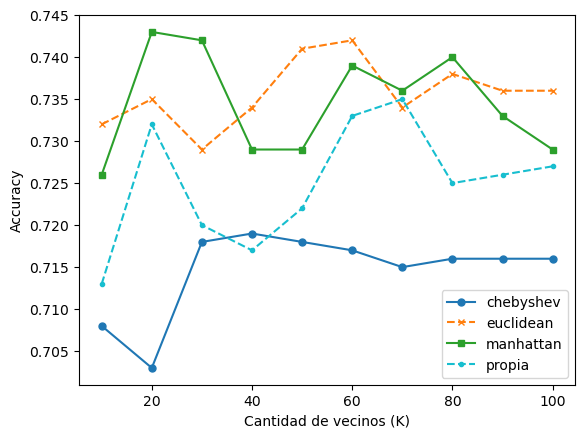

In [73]:
for name in dataResultados.groups.keys():
    group = dataResultados.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #SIN EFECTO SUAVIZADO
    if name=='euclidean': plt.plot(valoresK, valores, marker='x', linestyle='--', color='C1', ms=5, label = name) 
    if name=='manhattan': plt.plot(valoresK, valores, marker='s', linestyle='-', color='C2', ms=5, label = name)    
    if name=='propia': plt.plot(valoresK, valores, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(valoresK, valores, marker='.', linestyle='-', color='C0', ms=10, label = name)
    #plt.title("Resultados")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X 
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

Se agrega un efecto suavizado (creación de curvas de ajuste) y más puntos mediante una interpolación. La interpolación es un proceso matemático que implica estimar valores desconocidos o faltantes entre dos o más puntos de datos conocidos. Se utiliza para crear una función suave que pase a través de los puntos de datos existentes y permita predecir o estimar valores para ubicaciones o puntos intermedios.

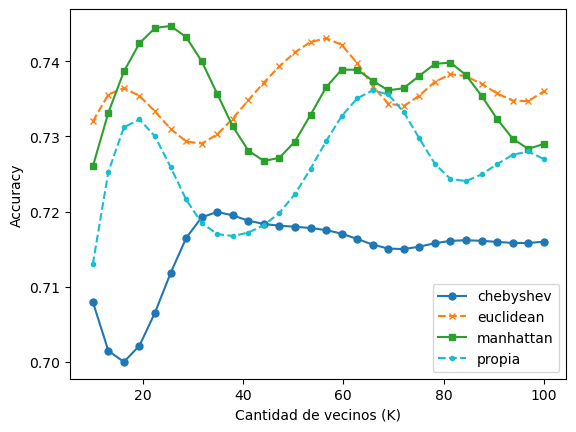

In [74]:
from scipy.interpolate import make_interp_spline, BSpline 
for name in dataResultados.groups.keys():
    group = dataResultados.get_group(name)
    #print(name)
    valores=group.ACC.values.tolist()
    #print(valores)
    #EFECTO SUAVIZADO: GENERAR PUNTOS CON UNA REGRESIÓN ENTRE LOS VALORES QUE TENEMOS
    numeroPuntos=len(valoresK)*3  #representa el número de puntos para generar entre T.min and T.max 
    xnew = np.linspace(min(valoresK),max(valoresK),numeroPuntos) #linspace genera puntos en un rango
    spl = make_interp_spline(valoresK, valores, k=3) #BSpline object 
    power_smooth = spl(xnew)         
    if name=='euclidean': plt.plot(xnew, power_smooth, marker='x', linestyle='--', color='C1', ms=5, label = name) 
    if name=='manhattan': plt.plot(xnew, power_smooth, marker='s', linestyle='-', color='C2', ms=5, label = name)    
    if name=='propia': plt.plot(xnew, power_smooth, marker='o', linestyle='--', color='C9', ms=3, label = name)
    if name=='chebyshev': plt.plot(xnew, power_smooth, marker='.', linestyle='-', color='C0', ms=10, label = name) 
        
    #plt.title("Resultados")
    plt.xlabel("Cantidad de vecinos (K)")   # Inserta el título del eje X 
    plt.ylabel("Accuracy")   # Inserta el título del eje Y
    plt.legend(loc="lower right")

### Diseño y entrenamiento del modelo optimizado

In [75]:
#Construcción de modelo KNN
model=KNeighborsRegressor(n_neighbors=25, metric='manhattan')#euclidean,manhattan,minkowski,chebyshev 
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_Transformado, Y, test_size = 0.2)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
history = model.fit(X_train, y_train)
print('Modelo entrenado')
#Se guarda el modelo entrenado
guardarModelo(model,'modeloKNN')
print('Modelo Optimizado Guardado')

(800, 30) (800,)
(200, 30) (200,)
Modelo entrenado
********** Pickle guardado
Modelo Optimizado Guardado


### Predicción con el conjunto de Test

In [76]:
#Predicciones
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal.head(10)

,real,predicción clase
707,0,1.0
927,0,0.0
803,1,1.0
249,0,1.0
325,1,1.0
180,0,1.0
981,0,1.0
863,1,1.0
992,1,1.0
204,1,1.0


### Evaluación de la calidad del modelo

Mean Absolute Error (MAE): 0.285
Mean Squared Error (MSE): 0.285
Root Mean Squared Error (RMSE): 0.5339
Accuracy: 0.715
Precision:  0.7337
Recall:  0.9118
F1: 0.8131
Matriz de confusión:
Verdaderos negativos:  19  Falsos positivos:  45  Falsos negativos:  12  Verdaderos positivos:  124


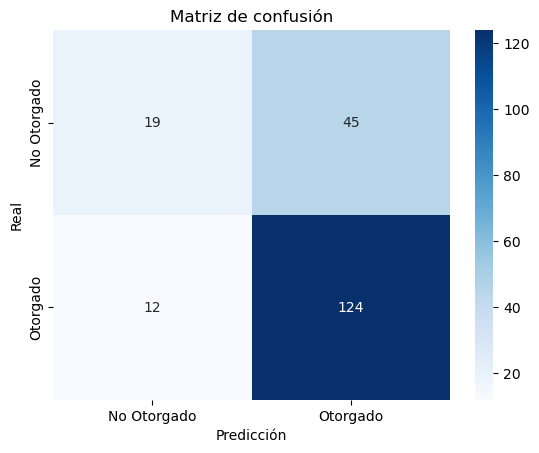

In [77]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)  
print('Mean Squared Error (MSE):', MSE)  
print('Root Mean Squared Error (RMSE):', RMSE) 

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase) 

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()  
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix  
labels = ['No Otorgado', 'Otorgado']
cm = confusion_matrix(y_testBinario, y_predBinario)  
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt='g'); #annot=True to annotate cells
ax.set_xlabel('Predicción');ax.set_ylabel('Real'); 
ax.set_title('Matriz de confusión'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);